In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
class layers():
    def __init__(self, output_dim, activation):
        self.output_dim= output_dim
        self.activation= activation
    
    def params(self, input_dim):
        self.W= np.random.rand(self.output_dim, input_dim)-0.5
        self.b= np.random.rand(self.output_dim,1)-0.5

        return [self.W, self.b, self.activation]
    

class Model():
    def __init__(self,*args):
        self.neural_net= args
    

    def forward_pass(self,W_arr,b_arr,activation_arr,input):
        a_arr,z_arr=[input],[]
        for i in range(0, len(self.neural_net)):
            input_dim= input.shape[0]
            z= W_arr[i].dot(input)+b_arr[i]

            if activation_arr[i]=='relu':
                a= np.maximum(z,0)
            elif activation_arr[i]== 'softmax':
                exp_val= np.exp(z)
                a= exp_val/(np.sum(exp_val, axis=0))

            input= a
            a_arr.append(a)
            z_arr.append(z)
        
        return [z_arr,a_arr,a]

    def backward_pass(self,W_arr,b_arr,a_arr,z_arr,y_pred,y_real,lr, last_activation, shape):
        dL_dzi= (y_pred-y_real)
        dL_dw_arr, dL_db_arr=[],[]
        for i in reversed(range(len(W_arr))):
            index= i+1
            if i== len(W_arr)-1:
                if last_activation=='softmax':
                    dL_dwi= dL_dzi.dot(a_arr[i].T)
                elif last_activation=='relu':
                    dL_dwi= (dL_dzi*(z_arr[-1]>0)).dot(a_arr[i].T)
                dL_dw_arr.append(dL_dwi/shape)
                dL_db_val= (np.sum(dL_dzi,axis=1)/shape)
                dL_db_arr.append(np.array([dL_db_val]).T)
            else:

                dL_dzi= (W_arr[index].T.dot(dL_dzi))*(z_arr[i]>0)
                dL_dwi= dL_dzi.dot(a_arr[i].T)
                dL_dw_arr.append(dL_dwi/shape)
                dL_db_val= (np.sum(dL_dzi,axis=1)/shape)
                dL_db_arr.append(np.array([dL_db_val]).T)

        dL_dw_arr= dL_dw_arr[::-1]
        dL_db_arr= dL_db_arr[::-1]
        
        # print([dL_dw_arr[i].shape for i in range(0, len(dL_dw_arr))])
        # print([dL_db_arr[i].shape for i in range(0, len(dL_db_arr))])
        for i in range(0, len(W_arr)):
            W_arr[i]= W_arr[i]- lr*dL_dw_arr[i]
            b_arr[i]= b_arr[i]- lr*dL_db_arr[i]
        return [W_arr,b_arr]

    def compile(self, loss_func,lr):
        self.loss_func= loss_func
        self.lr= lr

    def error_func(self, y_real, y_pred):
        loss_func= self.loss_func
        if loss_func=='mse':
            error= 0.5*(np.sum((y_real-y_pred)**2))
        elif loss_func== 'sparse_cat_crossentropy':
            error= np.sum(-y_real*np.log(y_pred))
        return error


    def fit(self,X,y, epoch):
        input,y_real= X.T,y.T
        shape= input.shape[1]
        W_arr, b_arr, activation_arr=[],[],[]
        for i in range(0, len(self.neural_net)):
            input_dim= input.shape[0]
            W,b,activation= self.neural_net[i].params(input_dim)
            output= W.dot(input)+b
            input= output
            W_arr.append(W)
            b_arr.append(b)
            activation_arr.append(activation)

        input=X.T
        for i in range(0, epoch):
            z_arr,a_arr,y_pred= self.forward_pass(W_arr, b_arr, activation_arr, input)
            error= 0.5*np.sum((y_real-y_pred)**2)
            
            if (i%100==0):
             error= self.error_func(y_real, y_pred)
             print(error)
            #  print(y_real, y_pred)
             print()
            W_arr,b_arr=self.backward_pass(W_arr, b_arr,a_arr, z_arr, y_pred, y_real,self.lr, self.neural_net[-1].activation, shape)
        self.W_arr, self.b_arr, self.activation_arr= W_arr, b_arr, activation_arr


    def predict(self, X):
         input= X.T
         W_arr, b_arr, activation_arr= self.W_arr, self.b_arr, self.activation_arr
         z_arr,a_arr,y_pred= self.forward_pass(W_arr, b_arr, activation_arr, input)
         return y_pred

def ohe_convert(y):
    ohe_vals= np.unique(y)
    ohe= np.zeros((len(y),len(ohe_vals)))

    for i in range(0, len(y)):
        ohe_loc= np.where(y[i]==ohe_vals)
        ohe[i][ohe_loc]=1

    return ohe


In [3]:
df= pd.read_csv('housing.csv')
df.drop(columns='Address', inplace=True)
df['Price']= df['Price']/(1e6)
df['Area Population']= df['Area Population']/10000
df['Avg. Area Income']= df['Avg. Area Income']/10000
df= df.loc[0:500]

X,y= df.drop(columns='Price'), df['Price']
# X= pd.DataFrame({'avg_area_income':df['Avg. Area Income']})
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, shuffle=True)
X, y=X_train, np.array([y_train]).T
y_test= np.array([y_test]).T

model= Model(layers(10,'relu'), layers(5, 'relu'), layers(1,'relu'))
model.compile('mse',0.1)
model.fit(X,y,1000)
y_pred= model.predict(X_test).T


error= 0.5*np.sum((y_test-y_pred)**2)
# plt.scatter(X_test, y_test)
# plt.plot(X_test, y_pred, color='Red')
print('test error', error)

205.41853076730843

24.68656064464888

24.67927948346403

24.645153796679693

24.335296659376063

21.97128586792978

18.791829136486832

15.640631012557748

12.499408871708374

9.539464373754226

test error 3.621976053949084


69.85868775952912

16.905630713820877

16.38661176573757

16.057936546033844

15.868314601110118

15.77104950389504

15.723282220787368

15.701162635962909

15.690456954062872

15.685232178106423

15.682694403336829

15.688365919817546

15.904717356011215

15.98487284841971

15.724448983003915

15.70266505733498

15.728727445198864

15.793248296948633

15.798461678324829

15.74945549292183

test error 3.362182708219506


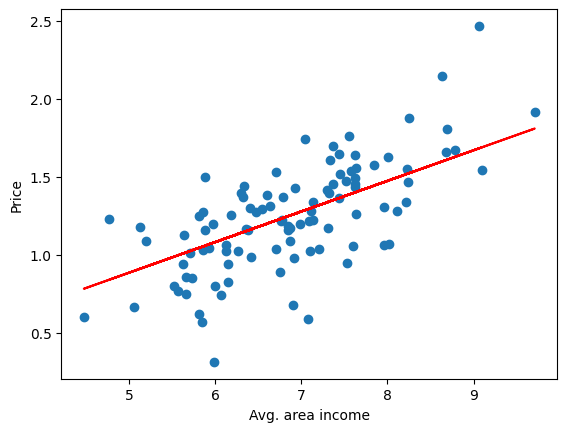

In [15]:
df= pd.read_csv('housing.csv')
df.drop(columns='Address', inplace=True)
df['Price']= df['Price']/(1e6)
df['Area Population']= df['Area Population']/10000
df['Avg. Area Income']= df['Avg. Area Income']/10000
df= df.loc[0:500]

X,y= df.drop(columns='Price'), df['Price']
X= pd.DataFrame({'avg_area_income':df['Avg. Area Income']})
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, shuffle=True)
X, y=X_train, np.array([y_train]).T
y_test= np.array([y_test]).T

model= Model(layers(10,'relu'), layers(5, 'relu'), layers(1,'relu'))
model.compile('mse',0.1)
model.fit(X,y,2000)
y_pred= model.predict(X_test).T


error= 0.5*np.sum((y_test-y_pred)**2)
plt.scatter(X_test, y_test, label='Test_data')
plt.plot(X_test, y_pred, color='Red', label='Predicted_data')
plt.xlabel('Avg. area income')
plt.ylabel('Price')
print('test error', error)

In [17]:
from sklearn.datasets import load_iris

iris= load_iris()
X,y= iris.data, iris.target

cols= iris.feature_names
cols.append('labels')
df= pd.DataFrame(columns= cols)

for i in range(0, len(X)):
    df.loc[len(df)]= np.append(X[i], y[i])

X,y= df.drop(columns='labels'), df['labels']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, shuffle=True)
X, y=X_train, np.array([y_train]).T

y_ohe= ohe_convert(y)
model= Model(layers(10,'relu'), layers(5, 'relu'), layers(3,'softmax'))
model.compile('sparse_cat_crossentropy',0.1)
model.fit(X,y_ohe,500)

y_pred= model.predict(X_test).T
y_pred= np.argmax(y_pred, axis=1)

acc= accuracy_score(y_test, y_pred)
cm= confusion_matrix(y_test, y_pred)

acc,cm

131.24258746162155

33.70961182077661

20.110623888887268

10.998631696880167

8.917884021088138



(0.9666666666666667,
 array([[ 8,  0,  0],
        [ 0,  9,  1],
        [ 0,  0, 12]], dtype=int64))